<a href="https://colab.research.google.com/github/vikashmaheshwari97/Concept-Drfit-Adaptation/blob/main/Credit_Card_CD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Multi-Stage Automated Online Network Data Stream Analytics Framework For IIoT Systems
This is the code for the paper entitled "**A Multi-Stage Automated Online Network Data Stream Analytics Framework For IIoT Systems**" accepted in *IEEE Transactions on Industrial Informatics* (IF: 11.648).  <br>
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  <br>
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

L. Yang and A. Shami, "A Multi-Stage Automated Online Network Data Stream Analytics Framework For IIoT Systems," IEEE Transactions on Industrial Informatics, pp. 1-10, 2022.

# 1. Load Data and Define Functions

## Import libraries

In [1]:
!pip install river==0.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for river: filename=river-0.7.0-cp310-cp310-linux_x86_64.whl size=2359432 sha256=3dd9d37e2af3514d3a1f486ed088c465adfc2cfaa2c186ed6bc393cde4256e9e
  Stored in directory: /root/.cache/pip/wheels/71/e9/7e/105173d51ebb5262f6f2dc4f6a5003ec86365255e8fd989733
Successfully built river


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import time

#import river, an online learning library
from river import feature_selection
from river import stats
from river import imblearn
from river import preprocessing
from river import evaluate
from river import metrics

In [7]:
import warnings
warnings.filterwarnings('ignore')

## Dataset 1: CICIDS2017
A subset of the network traffic data randomly sampled from the [CICIDS2017 dataset](https://www.unb.ca/cic/datasets/ids-2017.html).  

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.

## Read the sampled CICIDS2017 dataset

In [14]:
df = pd.read_csv("/content/card_transdata.csv")

df = df.sample(n=None, frac=0.1, random_state=None, axis=0)
df = df.sort_index()

In [15]:
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
6,3.724019,0.956838,0.278465,1.0,0.0,0.0,1.0,0.0
12,765.282559,0.371562,0.551245,1.0,1.0,0.0,0.0,0.0
49,42.735856,0.035699,1.806393,1.0,1.0,0.0,0.0,0.0
54,151.370437,5.340081,1.171567,1.0,0.0,0.0,1.0,1.0
67,39.021229,2.621358,1.199162,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999944,10.961039,0.833223,1.857067,1.0,0.0,0.0,0.0,0.0
999953,0.634517,0.041041,1.936955,0.0,1.0,0.0,0.0,0.0
999973,10.148074,4.465290,12.022734,1.0,0.0,1.0,0.0,0.0
999975,4.028273,2.379668,3.457429,1.0,0.0,0.0,1.0,0.0


In [16]:
# Cheking percent of missing values in columns
df_missing_columns = (round(((df.isnull().sum()/len(df.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

,null
distance_from_home,0.0
distance_from_last_transaction,0.0
ratio_to_median_purchase_price,0.0
repeat_retailer,0.0
used_chip,0.0
used_pin_number,0.0
online_order,0.0
fraud,0.0


## Train-test split
10% training set, and 90% test set

In [17]:
X = df.drop(['fraud'],axis=1)
y = df['fraud']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.2, test_size = 0.8, shuffle=False,random_state = 0)

## Basic Adaptive Learning - Define Functions

In [18]:
# Import the online learning metrics and algorithms from the River library
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.drift import DDM, ADWIN,EDDM,HDDM_A,HDDM_W,KSWIN,PageHinkley

In [19]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    
    eddm = EDDM()
    
    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1) 

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric = metric.update(yi, y_pred) # Update the real-time accuracy
        
        #drift_detection part
        val = 0
        if yi != y_pred:
            val = 1 
        in_drift, in_warning = eddm.update(float(val))
        if in_drift:
            print(f"Change detected at index {i}")
        
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

In [20]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on CICIDS2017 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Change detected at index 3241
Change detected at index 12562
Change detected at index 15577
Change detected at index 19632
Change detected at index 23678
Change detected at index 26536
Change detected at index 30637
Change detected at index 32696
Change detected at index 34856
Change detected at index 36622
Change detected at index 40228
Change detected at index 43501
Change detected at index 46438
Change detected at index 50221
Change detected at index 53143
Change detected at index 56513
Change detected at index 60267
Accuracy: 98.97%
Precision: 97.39%
Recall: 90.68%
F1-score: 93.91000000000001%
CPU times: user 1min 11s, sys: 3.29 s, total: 1min 14s
Wall time: 1min 13s


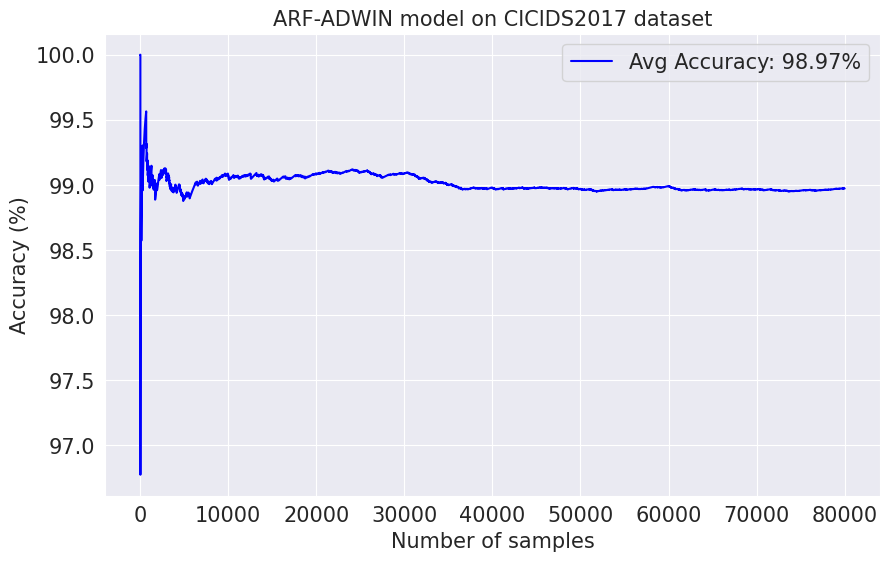

In [21]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector as a baseline model
name1 = "ARF-ADWIN model"
model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

# 2. Dynamic Data Pre-Processing

The dynamic data pre-processing part focuses on data balancing and data normalization. Examples of using them are given below.   
* Data balancing methods include Dynamic Random Under-Sampling (DRUS) and Dynamic Random Over-Sampling (DROS);  
* Data normalization methods include dynamic min-max and Z-score scalers.  <br>


Change detected at index 99
Change detected at index 784
Change detected at index 887
Change detected at index 1761
Change detected at index 1966
Change detected at index 2157
Change detected at index 3221
Change detected at index 3499
Change detected at index 3896
Change detected at index 4456
Change detected at index 5297
Change detected at index 5976
Change detected at index 6596
Change detected at index 7171
Change detected at index 7651
Change detected at index 7887
Change detected at index 8281
Change detected at index 8582
Change detected at index 9144
Change detected at index 10010
Change detected at index 10513
Change detected at index 10998
Change detected at index 11705
Change detected at index 12152
Change detected at index 13258
Change detected at index 13703
Change detected at index 14138
Change detected at index 14433
Change detected at index 14694
Change detected at index 14965
Change detected at index 15273
Change detected at index 15532
Change detected at index 15989


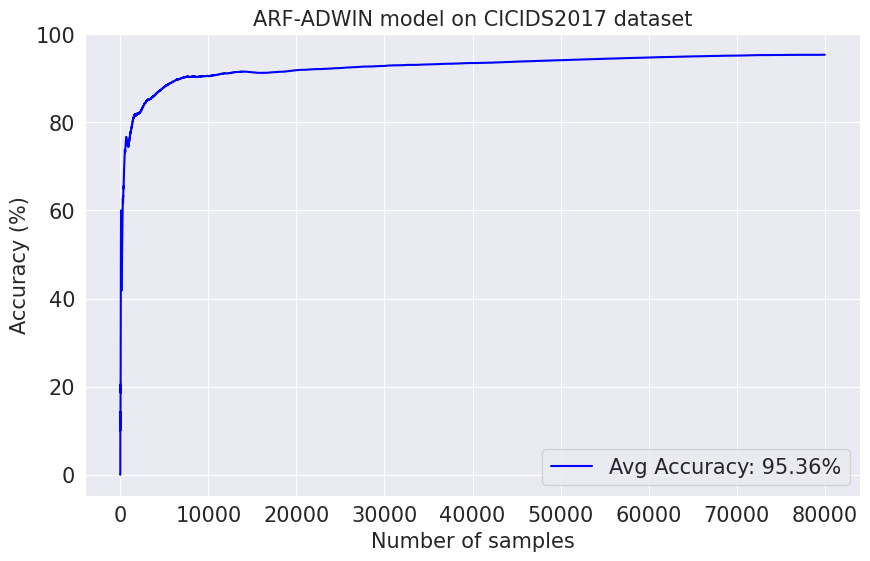

In [22]:
%%time
# Min-max normalization & random under-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomUnderSampler( (
                                    preprocessing.MinMaxScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.4, 1: 0.6}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 2/3. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 75
Change detected at index 150
Change detected at index 291
Change detected at index 2127
Change detected at index 2231
Change detected at index 2372
Change detected at index 2637
Change detected at index 2853
Change detected at index 3083
Change detected at index 3323
Change detected at index 3766
Accuracy: 95.39999999999999%
Precision: 65.82000000000001%
Recall: 98.58%
F1-score: 78.94%
CPU times: user 25 s, sys: 1.19 s, total: 26.1 s
Wall time: 25.4 s


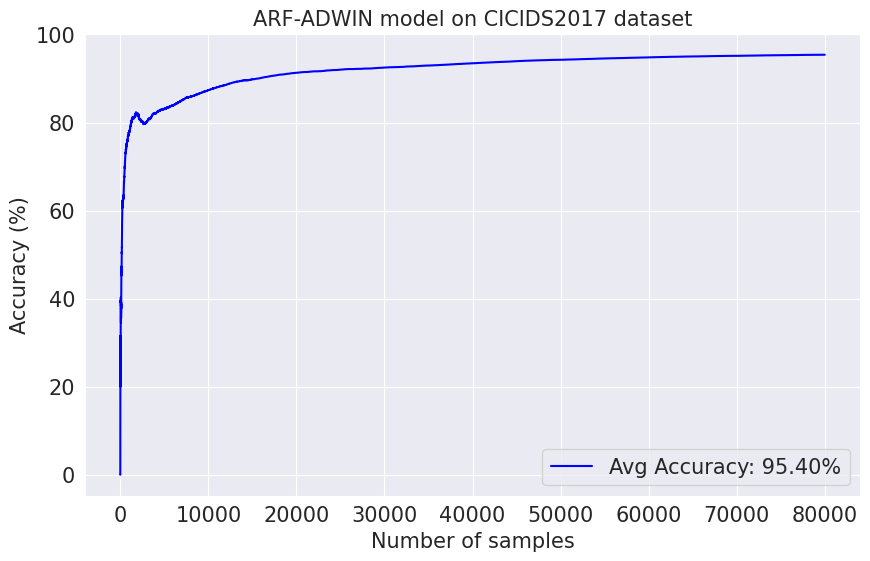

In [23]:
%%time
# Z-score normalization & random under-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomUnderSampler( (
                                    preprocessing.StandardScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.4, 1: 0.6}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 2/3. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 1786
Change detected at index 2716
Change detected at index 3148
Change detected at index 3829
Change detected at index 4755
Change detected at index 5150
Change detected at index 6465
Change detected at index 7457
Change detected at index 8173
Change detected at index 22707
Change detected at index 23676
Change detected at index 24608
Change detected at index 25070
Change detected at index 25901
Change detected at index 26598
Change detected at index 27314
Change detected at index 27749
Change detected at index 28394
Change detected at index 29176
Change detected at index 30316
Change detected at index 31427
Change detected at index 32874
Change detected at index 33285
Change detected at index 34846
Change detected at index 35427
Change detected at index 36391
Change detected at index 36764
Change detected at index 49504
Change detected at index 50056
Change detected at index 50521
Change detected at index 51036
Change detected at index 51383
Change detected a

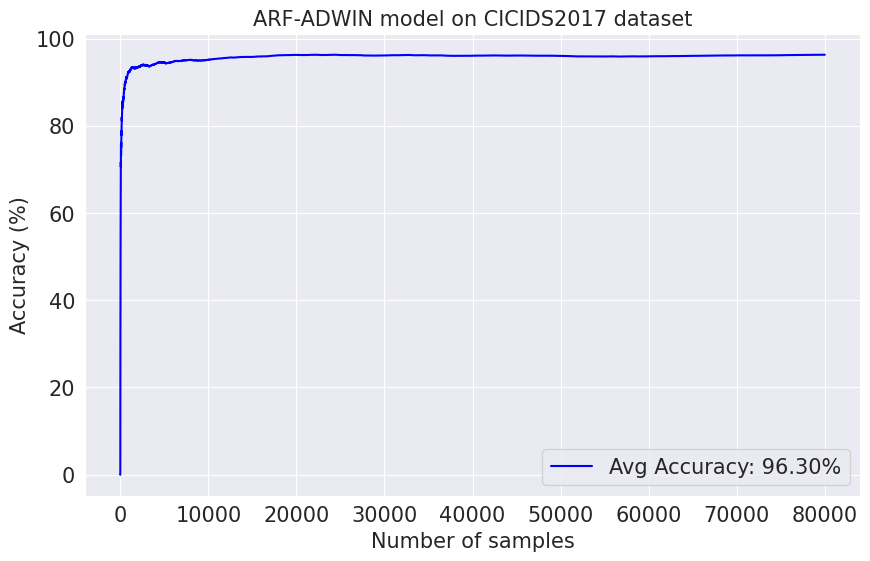

In [25]:
%%time
# Min-max normalization & random over-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomOverSampler( (
                                    preprocessing.MinMaxScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.4, 1: 0.6}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 2/3. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 97
Change detected at index 1617
Change detected at index 1926
Change detected at index 2710
Change detected at index 3148
Change detected at index 3405
Change detected at index 3787
Change detected at index 4658
Change detected at index 4883
Change detected at index 5297
Change detected at index 5889
Change detected at index 6356
Change detected at index 6800
Change detected at index 7395
Change detected at index 8150
Change detected at index 8944
Change detected at index 9445
Change detected at index 10015
Change detected at index 19389
Change detected at index 20627
Change detected at index 21082
Change detected at index 21481
Change detected at index 33025
Change detected at index 33359
Change detected at index 33694
Change detected at index 34542
Change detected at index 49775
Change detected at index 50067
Change detected at index 50320
Change detected at index 50836
Change detected at index 51295
Change detected at index 51842
Change detected at index 52

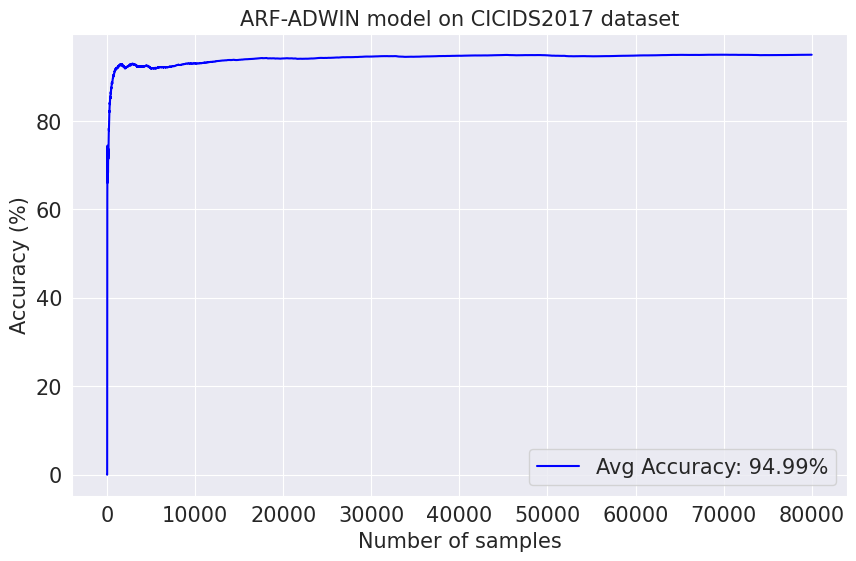

In [26]:
%%time
# Z-score normalization & random over-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomOverSampler( (
                                    preprocessing.StandardScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.4, 1: 0.6}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 2/3. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

# 3. Model Learning

## Base Model Learning for Comparison Purposes
State-of-the-art online learning models:
* Adaptive Random Forest (ARF) with ADWIN drift detector
* Adaptive Random Forest (ARF) with EDDM drift detector
* Streaming Random Patches (SRP)
* Extremely Fast Decision Tree (EFDT)
* K-Nearest Neighbors (KNN) classifier with ADWIN change detector (KNN-ADWIN)
* Self Adapting Memory (SAM) KNN model (SAM-KNN)
* Online Passive-Aggressive (OPA)
* Leveraging Bagging (LB)
* Performance Weighted Probability Averaging Ensemble (PWPAE)
  * Proposed in the previous work
* Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE)
  * Proposed

Change detected at index 2632
Change detected at index 18640
Change detected at index 21337
Change detected at index 24343
Change detected at index 26978
Change detected at index 31017
Accuracy: 99.16%
Precision: 97.32%
Recall: 92.91%
F1-score: 95.06%
CPU times: user 1min 11s, sys: 3.23 s, total: 1min 14s
Wall time: 1min 13s


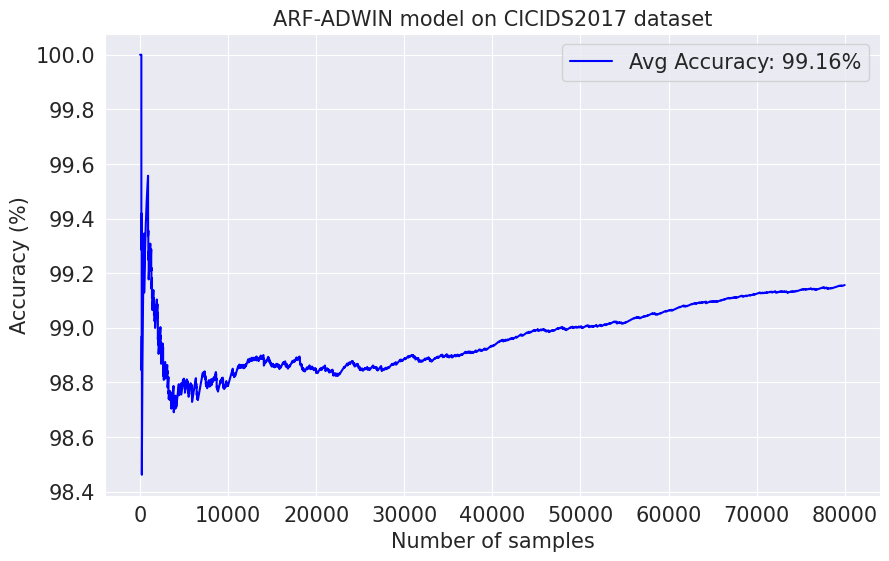

In [27]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector
name1 = "ARF-ADWIN model"
model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 3423
Change detected at index 8642
Change detected at index 15281
Change detected at index 27356
Change detected at index 37333
Change detected at index 51770
Change detected at index 63640
Change detected at index 72190
Accuracy: 99.56%
Precision: 98.14%
Recall: 96.75%
F1-score: 97.44%
CPU times: user 1min 25s, sys: 3.47 s, total: 1min 29s
Wall time: 1min 27s


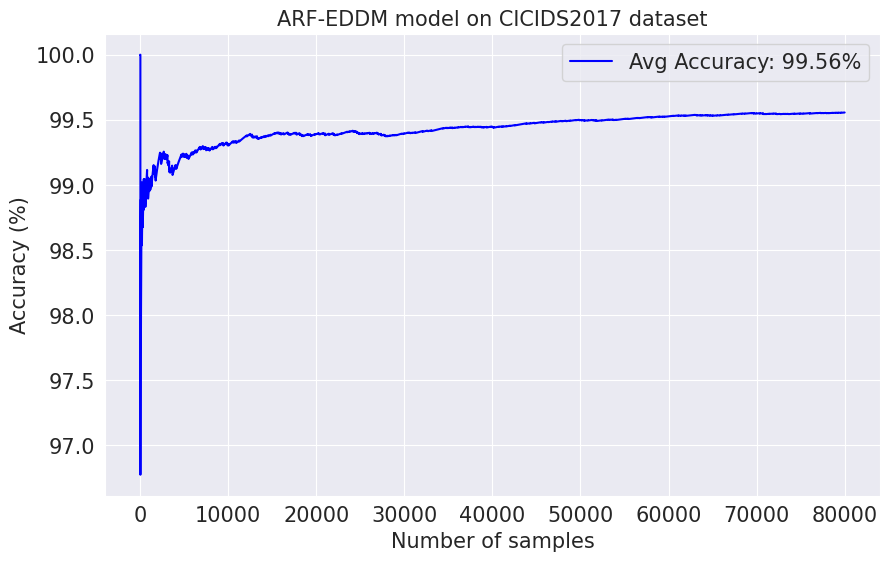

In [28]:
%%time
# Use the Adaptive Random Forest (ARF) model with EDDM drift detector
name2 = "ARF-EDDM model"
model2 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = EDDM()) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 2098
Change detected at index 2985
Change detected at index 3520
Change detected at index 4009
Change detected at index 4500
Change detected at index 5060
Change detected at index 5655
Change detected at index 6236
Change detected at index 6934
Change detected at index 7417
Change detected at index 7924
Change detected at index 8379
Change detected at index 8855
Change detected at index 9317
Change detected at index 10463
Change detected at index 11911
Change detected at index 12602
Change detected at index 13332
Change detected at index 13918
Change detected at index 14437
Change detected at index 14820
Change detected at index 16282
Change detected at index 17524
Change detected at index 18087
Change detected at index 18726
Change detected at index 19337
Change detected at index 20442
Change detected at index 20936
Change detected at index 21363
Change detected at index 21902
Change detected at index 22482
Change detected at index 28224
Change detected at ind

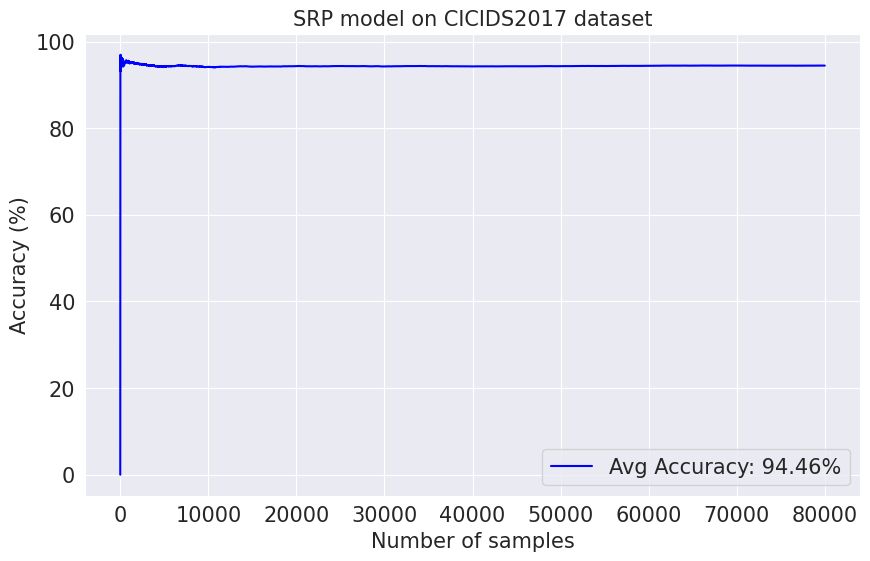

In [29]:
%%time
# Use the Streaming Random Patches (SRP) model
name3 = "SRP model"
model3 = ensemble.SRPClassifier(n_models = 3) # Define the model
t, m3 = adaptive_learning(model3, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m3, name3) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 1432
Change detected at index 2937
Accuracy: 98.85000000000001%
Precision: 94.23%
Recall: 92.47999999999999%
F1-score: 93.35%
CPU times: user 6min 28s, sys: 1.42 s, total: 6min 30s
Wall time: 6min 31s


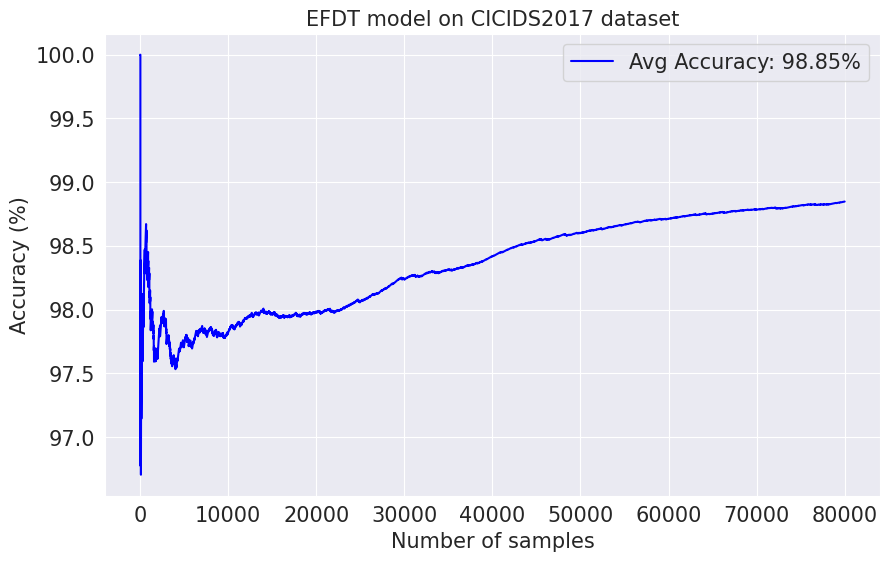

In [30]:
%%time
# Use the Extremely Fast Decision Tree (EFDT) model 
name4 = "EFDT model"
model4 = tree.ExtremelyFastDecisionTreeClassifier() # Define the model
t, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m4, name4) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 1020
Change detected at index 1638
Change detected at index 1971
Change detected at index 3206
Change detected at index 3515
Change detected at index 3816
Change detected at index 4139
Change detected at index 4492
Change detected at index 4861
Change detected at index 5227
Change detected at index 5658
Change detected at index 6837
Change detected at index 7326
Accuracy: 91.28%
Precision: 50.28%
Recall: 18.12%
F1-score: 26.640000000000004%
CPU times: user 24.5 s, sys: 146 ms, total: 24.6 s
Wall time: 24.6 s


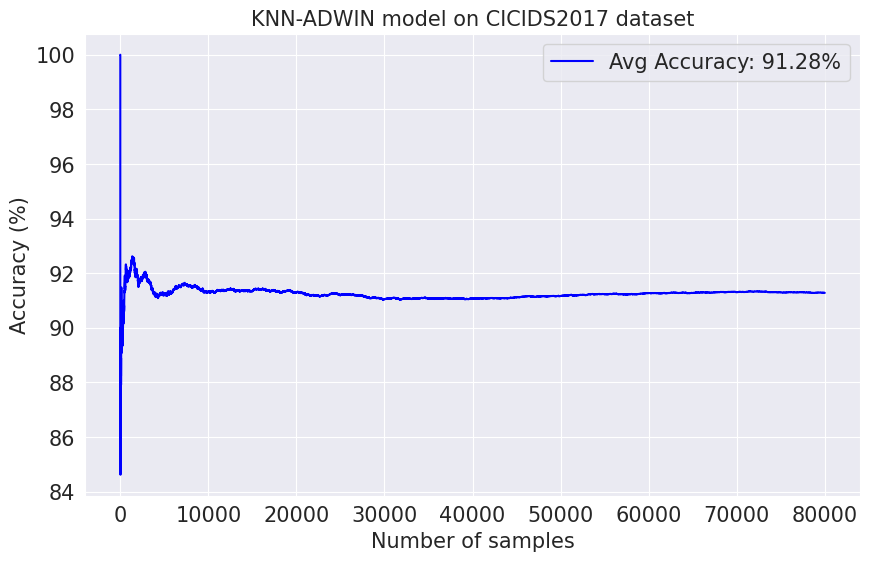

In [31]:
%%time
# Use the K-Nearest Neighbors (KNN) classifier with ADWIN change detector
name5 = "KNN-ADWIN model"
model5 = neighbors.KNNADWINClassifier(window_size=100) # Define the model
t, m5 = adaptive_learning(model5, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m5, name5) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 289
Change detected at index 731
Change detected at index 1950
Change detected at index 3100
Change detected at index 3437
Accuracy: 91.23%
Precision: 49.19%
Recall: 11.24%
F1-score: 18.3%
CPU times: user 2min 21s, sys: 870 ms, total: 2min 22s
Wall time: 1min 20s


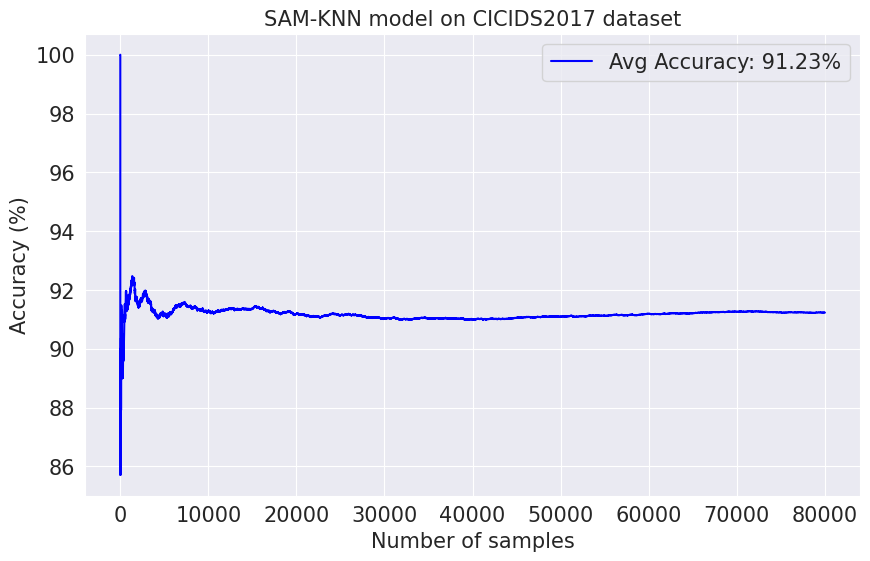

In [32]:
%%time
# Use the Self Adapting Memory (SAM) KNN model 
name6 = "SAM-KNN model"
model6 = neighbors.SAMKNNClassifier(window_size=100) # Define the model
t, m6 = adaptive_learning(model6, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m6, name6) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 293
Change detected at index 708
Change detected at index 1059
Change detected at index 1545
Change detected at index 1938
Change detected at index 3528
Change detected at index 3784
Change detected at index 4284
Change detected at index 4707
Change detected at index 5061
Change detected at index 5495
Change detected at index 5831
Change detected at index 6783
Change detected at index 7121
Change detected at index 7510
Change detected at index 7800
Accuracy: 92.19000000000001%
Precision: 55.44%
Recall: 54.279999999999994%
F1-score: 54.86%
CPU times: user 9.2 s, sys: 734 ms, total: 9.94 s
Wall time: 9.48 s


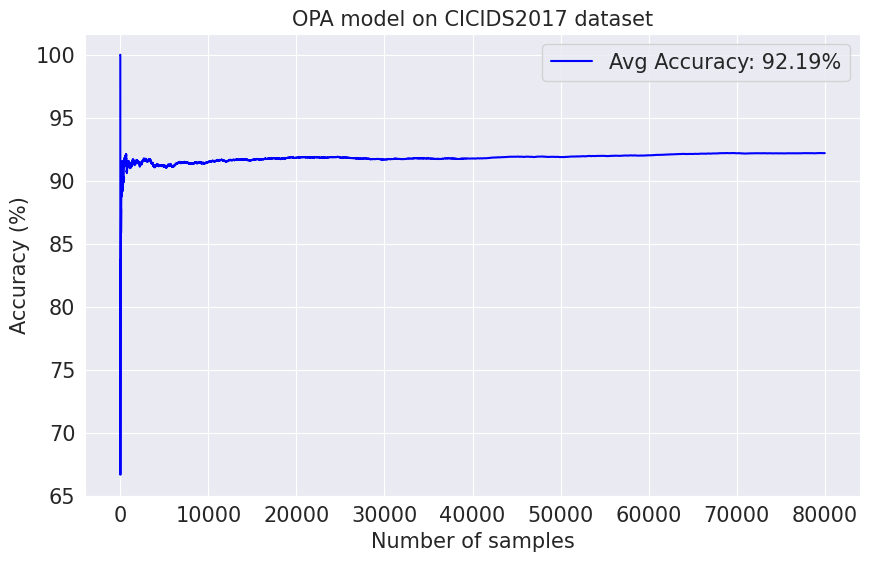

In [33]:
%%time
# Use the Online Passive-Aggressive (OPA) model
name7 = "OPA model"
model7 = linear_model.PAClassifier() # Define the model
t, m7 = adaptive_learning(model7, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m7, name7) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 5703
Change detected at index 26027
Change detected at index 33406
Change detected at index 46569
Change detected at index 67618
Accuracy: 99.72%
Precision: 98.5%
Recall: 98.34%
F1-score: 98.42%
CPU times: user 2min 6s, sys: 1.21 s, total: 2min 7s
Wall time: 2min 7s


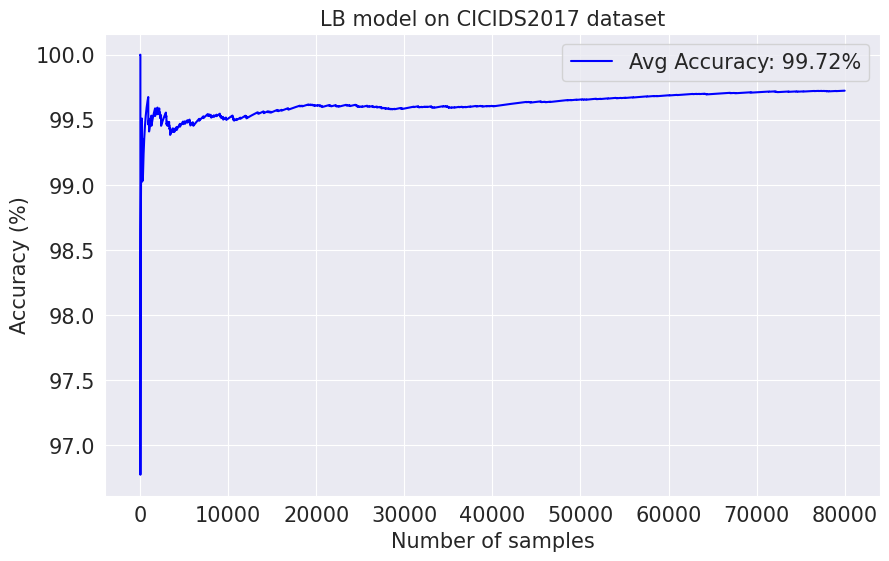

In [34]:
%%time
# Use the Leveraging Bagging (LB) model 
name8 = "LB model"
model8 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # Define the model
t, m8 = adaptive_learning(model8, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m8, name8) # Draw the figure of how the real-time accuracy changes with the number of samples

In [35]:
# Define the Performance Weighted Probability Averaging Ensemble (PWPAE) model
# proposed in our previous work: https://github.com/Western-OC2-Lab/PWPAE-Concept-Drift-Detection-and-Adaptation
def PWPAE(X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = ensemble.SRPClassifier(n_models=2) # SRP-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # ARF-DDM
    hat4 = ensemble.SRPClassifier(n_models=2,drift_detector=DDM(),warning_detector=DDM()) # SRP-DDM

    selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
    selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=15)
    # Initial FS
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        selector1.learn_one(xi1) 
    
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        selector2.learn_one(xi1,yi1) 
        
    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        xi1 = selector2.transform_one(xi1)
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learner predict the labels
        xi = selector1.transform_one(xi)
        xi = selector2.transform_one(xi)
        y_pred1= hat1.predict_one(xi) 
        y_prob1= hat1.predict_proba_one(xi) 
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi) 
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi) 
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi) 
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)
        
        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)    

        # Calculate the real-time error rates of four base learners
        e1 = 1-metric1.get()
        e2 = 1-metric2.get()
        e3 = 1-metric3.get()
        e4 = 1-metric4.get()

        
        ep = 0.001 # The epsilon used to avoid dividing by 0
        # Calculate the weight of each base learner by the reciprocal of its real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]        

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1
        
        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        
        i=i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

Accuracy: 98.11999999999999%
Precision: 90.27%
Recall: 87.94999999999999%
F1-score: 89.09%
CPU times: user 6min 3s, sys: 11.9 s, total: 6min 15s
Wall time: 6min 9s


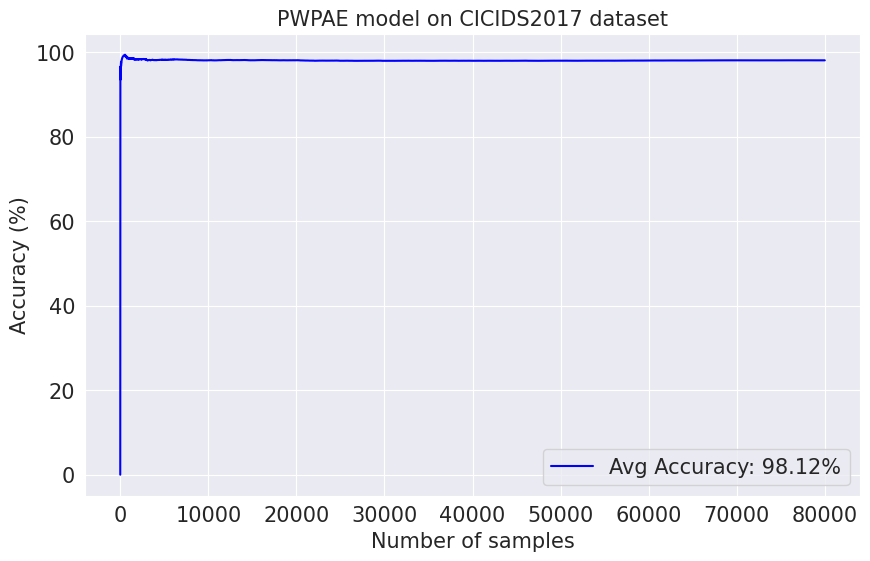

In [36]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name9 = "PWPAE model"
t, m9 = PWPAE(X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m9, name9) # Draw the figure of how the real-time accuracy changes with the number of samples

# 4. Proposed Multi-Stage Automated Network Analytics (MSANA) Framework
Main Module 1: Drift-based Dynamic Feature Selection  
Main Module 2: Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE)

In [37]:
# Define the Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE) model
# An extension method of the PWPAE model
def MSANA(model1, model2, model3, model4, X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()
    
    metric_w1 = []
    metric_w2 = []
    metric_w3 = []
    metric_w4 = []


    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = model1
    hat2 = model2
    hat3 = model3
    hat4 = model4
    
    # Define the two feature selections methods: Variance Threshold and Select-K-Best
    selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
    selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=40)
    
    # Use EDDM to detect concept drift, it can be replaced with other drift detection methods like ADWIN, DDM, etc.
    eddm = EDDM()
    drift = 0

    # Initial feature selection on the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        selector1.learn_one(xi1) 
    
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        selector2.learn_one(xi1,yi1) 
        
    # Train the online models on the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        xi1 = selector2.transform_one(xi1)
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learners predict the labels
        xi = selector1.transform_one(xi)
        xi = selector2.transform_one(xi)
        y_pred1= hat1.predict_one(xi) 
        y_prob1= hat1.predict_proba_one(xi) 
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi) 
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi) 
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi) 
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)
        
        if y_pred1 == yi:
            metric_w1.append(0)
        else:
            metric_w1.append(1)
        if y_pred2 == yi:
            metric_w2.append(0)
        else:
            metric_w2.append(1)
        if y_pred3 == yi:
            metric_w3.append(0)
        else:
            metric_w3.append(1)
        if y_pred4 == yi:
            metric_w4.append(0)
        else:
            metric_w4.append(1)
        
        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)    

        
        # Calculate the real-time window error rates of four base learners
        if i<1000:
            e1 = 0
            e2 = 0
            e3 = 0
            e4 = 0
        else:        
            e1 = sum(metric_w1[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e2 = sum(metric_w2[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e3 = sum(metric_w3[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e4 = sum(metric_w4[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])

        
        ep = 0.001 # The epsilon used to avoid dividing by 0
        
        # Calculate the weight of each base learner by the reciprocal of its window real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]        

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41
        
#         print(str(i)+" "+str(w1)+" "+str(w2)+" "+str(w3)+" "+str(w4)+" "+str(y_prob_0)+" "+str(y_prob_1))

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1
        
        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)
        
        # Detect concept drift
        val = 0
        if yi != y_pred:
            val = 1 
        in_drift, in_warning = eddm.update(float(val))
        
        if in_drift & (i>1000) :
            print(f"Change detected at index {i}")
            drift = 1 # indicating that a drift occurs
        
        # If a drift is detected
        if drift == 1: 
            x_new = X_test[round(0.9*i):i]
            y_new = y_test[round(0.9*i):i]
            
            # Relearn the online models on the most recent window data (representing new concept data)
            hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
            hat2 = neighbors.KNNADWINClassifier(window_size=100)
            hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
            hat4 = linear_model.PAClassifier() # SRP-DDM
            
            # Re-select features
            selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
            selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=40)
            
            for xj, yj in stream.iter_pandas(x_new, y_new):
                selector1 = selector1.learn_one(xj)
            for xj, yj in stream.iter_pandas(x_new, y_new):
                xj = selector1.transform_one(xj)
                selector2 = selector2.learn_one(xj, yj)      
            for xj, yj in stream.iter_pandas(x_new, y_new):
                xj = selector1.transform_one(xj)
                xa = selector2.transform_one(xj)
                hat1.learn_one(xa,yj)
                hat2.learn_one(xa,yj)
                hat3.learn_one(xa,yj)
                hat4.learn_one(xa,yj)
                
                if j ==1:
                    print(len(xa))
                    j=0
            drift = 0   
        
        j=1
        

        t.append(i)
        m.append(metric.get()*100)
        
        yt.append(yi)
        yp.append(y_pred)
        
        i=i+1
    
    # outputs
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    print(metric1.get()*100)
    print(metric2.get()*100)
    print(metric3.get()*100)
    print(metric4.get()*100)
    return t, m

Change detected at index 1048
6
Change detected at index 1620
6
Change detected at index 1992
7
Change detected at index 3027
6
Change detected at index 3462
7
Change detected at index 4331
6
Change detected at index 5283
6
Change detected at index 6331
5
Change detected at index 7601
5
Change detected at index 8093
5
Change detected at index 8688
5
Change detected at index 9265
6
Change detected at index 9748
6
Change detected at index 10408
6
Change detected at index 11076
7
Accuracy: 98.78%
Precision: 97.72999999999999%
Recall: 88.13%
F1-score: 92.67999999999999%
98.57875
91.27625
98.55874999999999
91.58125
CPU times: user 3min 38s, sys: 853 ms, total: 3min 39s
Wall time: 3min 41s


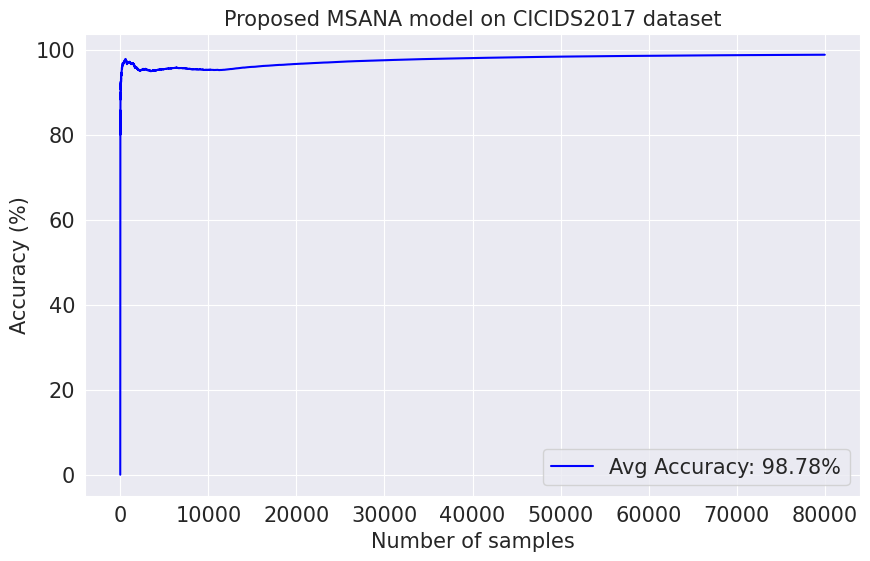

In [38]:
%%time
# Use the proposed Multi-Stage Automated Network Analytics (MSANA) model 

# Select the four base online models, they can be changed based on the performance of the models
bm1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
bm2 = neighbors.KNNADWINClassifier(window_size=100) # KNN-ADWIN
bm3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
bm4 = linear_model.PAClassifier() # OPA

name = "Proposed MSANA model"
t, m = MSANA(bm1, bm2, bm3, bm4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

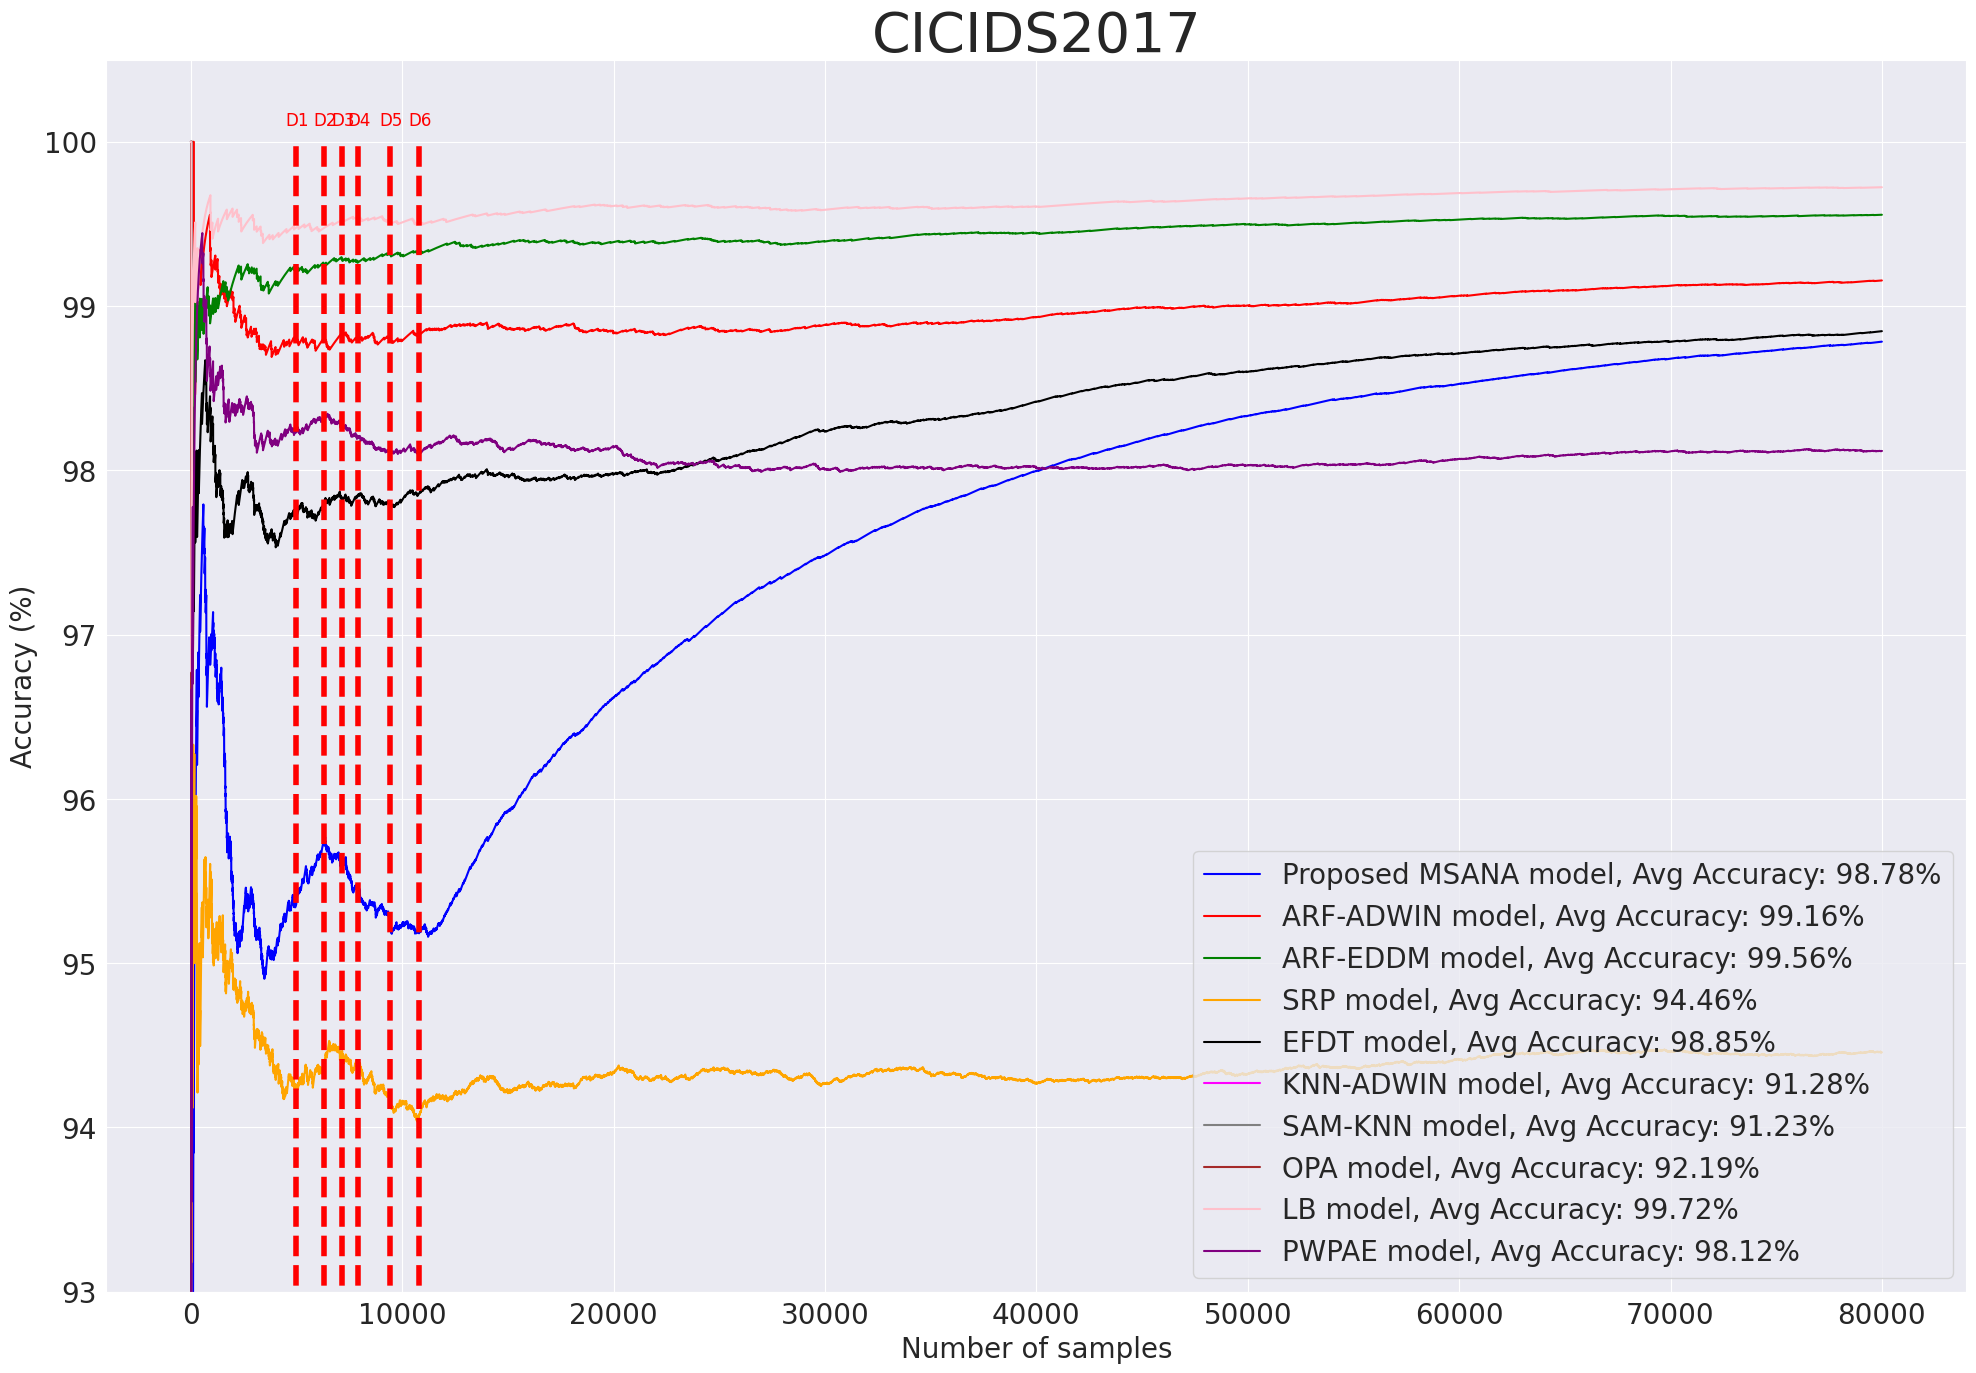

In [43]:
# Draw a comprehensive figure to compare the performance of all models
# https://matplotlib.org/stable/gallery/color/named_colors.html
plt.rcParams.update({'font.size': 20})
plt.figure(1,figsize=(24,16)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m,'-b',label=name+', Avg Accuracy: %.2f%%'%(m[-1]))
# plt.plot(t,m0,'pink',label=name0+', Avg Accuracy: %.2f%%'%(m0[-1]))
plt.plot(t,m1,'-r',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))
plt.plot(t,m5,'magenta',label=name5+', Avg Accuracy: %.2f%%'%(m5[-1]))
plt.plot(t,m6,'grey',label=name6+', Avg Accuracy: %.2f%%'%(m6[-1]))
plt.plot(t,m7,'brown',label=name7+', Avg Accuracy: %.2f%%'%(m7[-1]))
plt.plot(t,m8,'pink',label=name8+', Avg Accuracy: %.2f%%'%(m8[-1]))
plt.plot(t,m9,'purple',label=name9+', Avg Accuracy: %.2f%%'%(m9[-1]))

# Draw the drift points/time
dr = [0,4950,6300, 7140,7900,9400,10800]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-500, 100.1, 'D'+ str(i), c = "red", fontsize = 12)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")
        
plt.legend(loc='lower right')
plt.ylim(93, 100.5)
plt.title('CICIDS2017', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()

The performance of the proposed MSANA model outperforms other models. Please note that the results might be different when using different datasets or different subsets of the CICIDS2017 dataset.

Change detected at index 1399
7
Accuracy: 99.44%
Precision: 98.09%
Recall: 95.39999999999999%
F1-score: 96.72%
99.02625
91.19
99.07625
91.78625
CPU times: user 4min 1s, sys: 1.06 s, total: 4min 2s
Wall time: 4min 4s


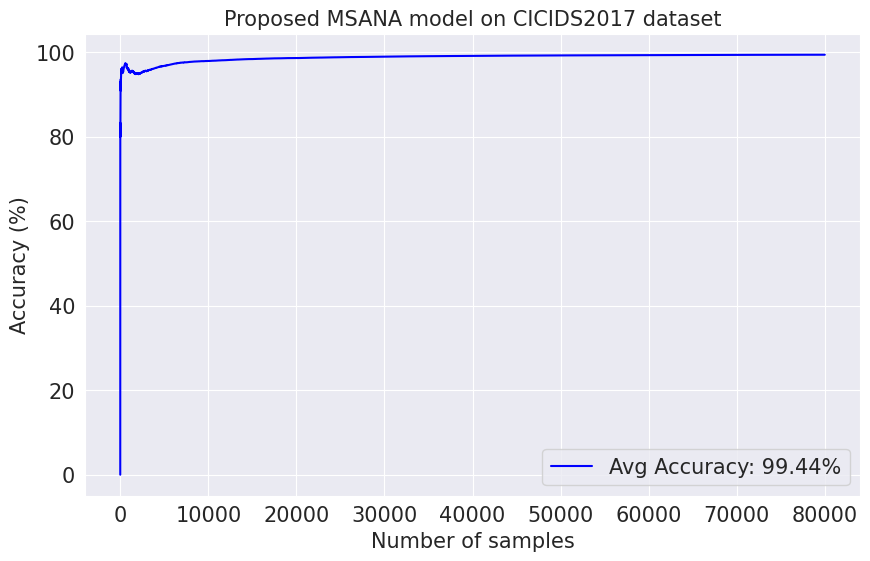

In [53]:
%%time
# Example: combine the ensemble model with dynamic data balancing methods.

bm1 = imblearn.RandomOverSampler(ensemble.AdaptiveRandomForestClassifier(n_models=3),
                                 desired_dist={0: .4, 1: .6},
                                seed=42
                                ) # ARF-ADWIN
bm2 = imblearn.RandomOverSampler(neighbors.KNNADWINClassifier(window_size=100),
                                 desired_dist={0: .4, 1: .6},
                                seed=42
                                ) # ARF-ADWIN
bm3 = imblearn.RandomOverSampler(ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()), # ARF-EDDM,
                                 desired_dist={0: .4, 1: .6},
                                seed=42
                                ) # ARF-ADWIN
bm4 = imblearn.RandomOverSampler(linear_model.PAClassifier(), # SRP-DDM
                                 desired_dist={0: .4, 1: .6},
                                seed=42
                                ) # ARF-ADWIN

name = "Proposed MSANA model"
t, m = MSANA(bm1, bm2, bm3, bm4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

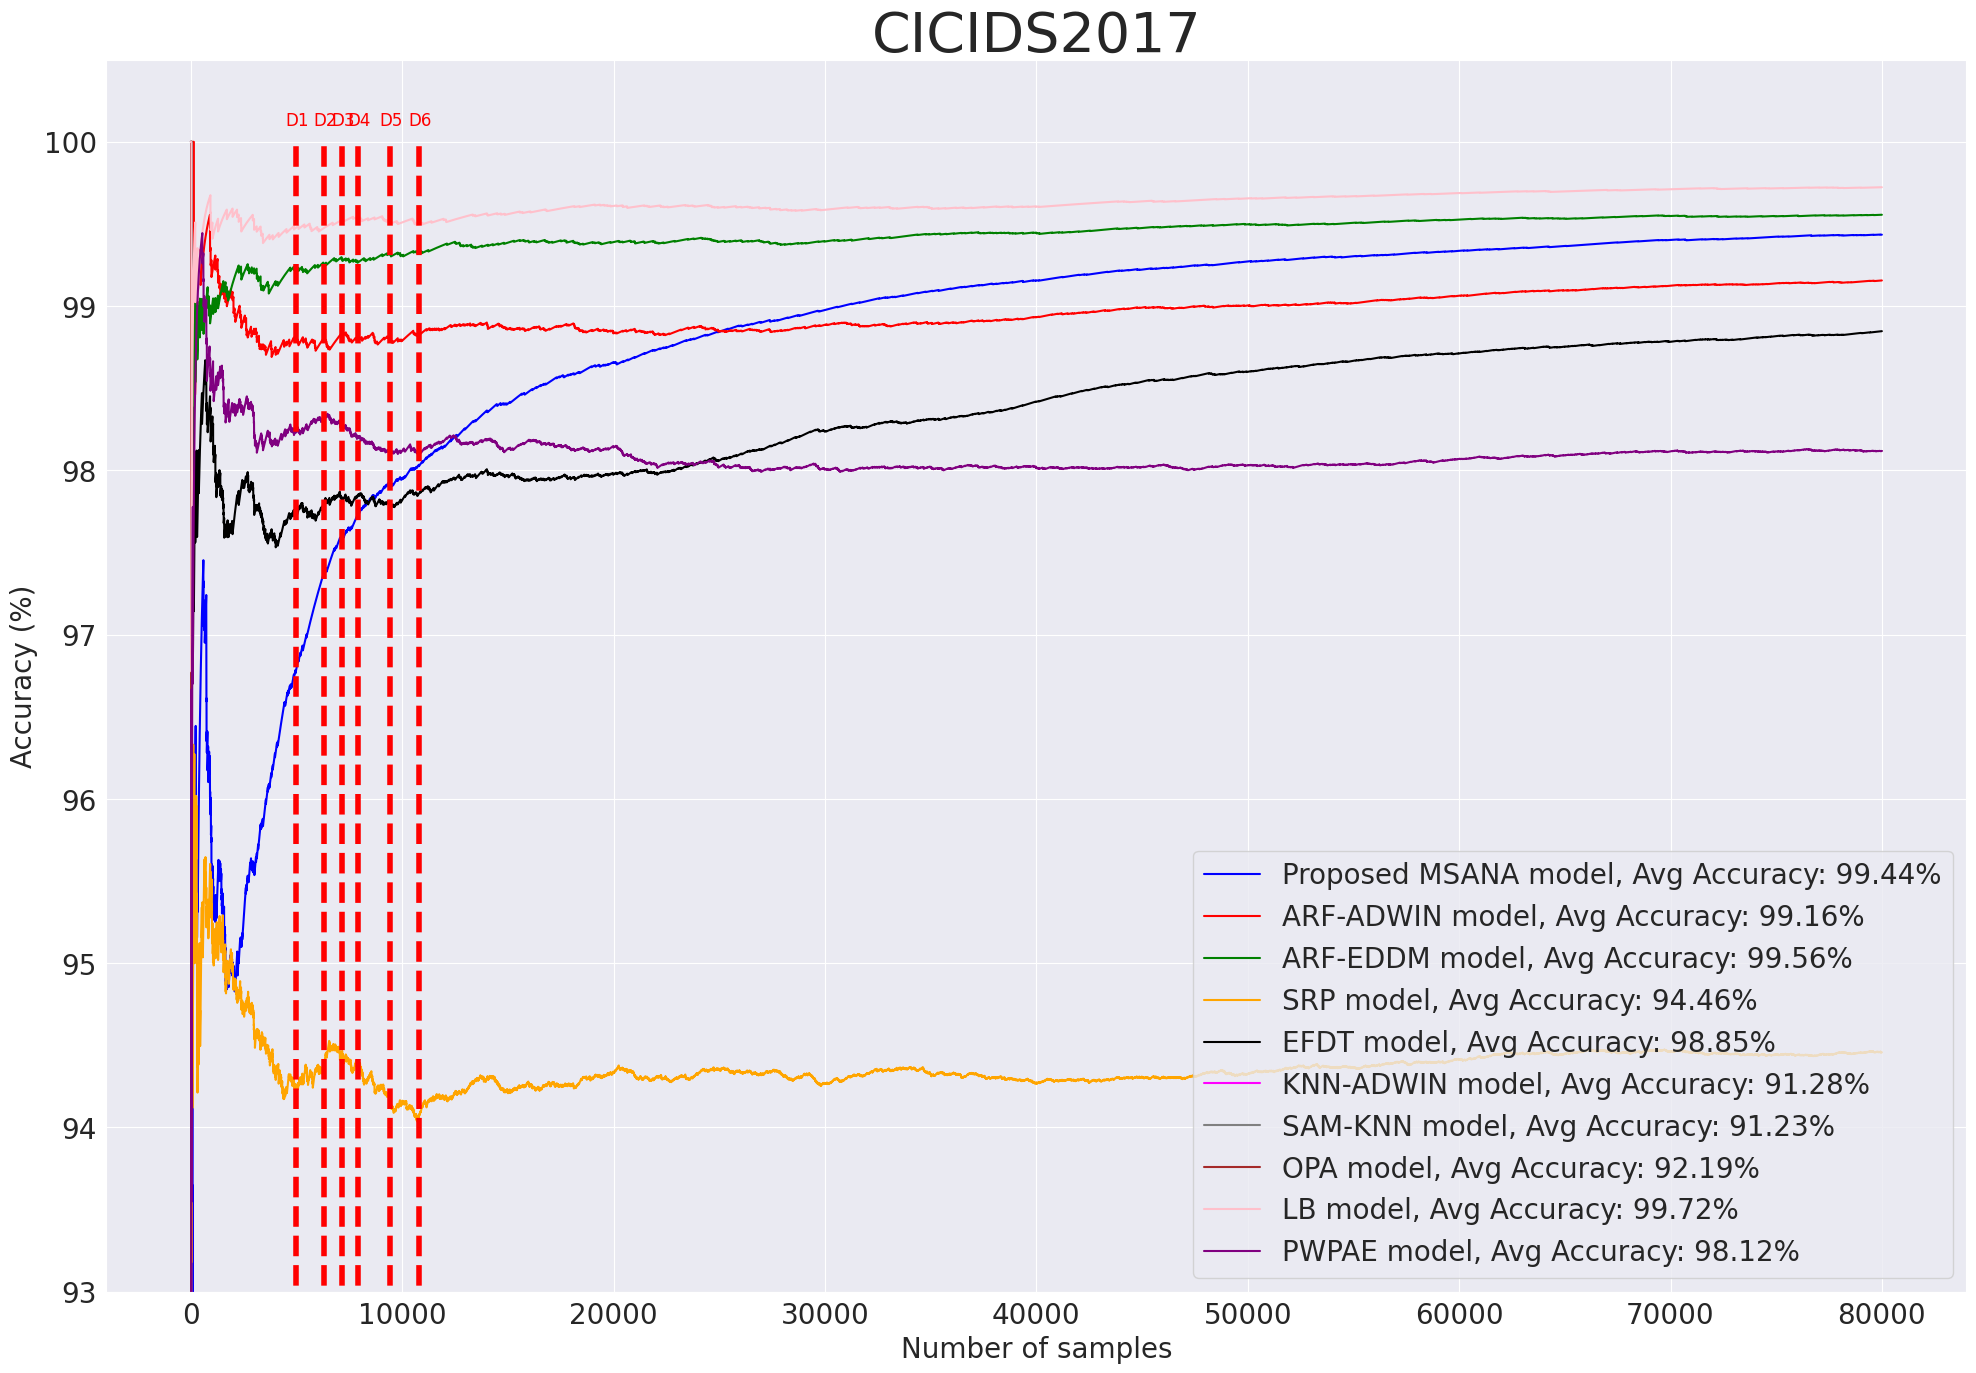

In [62]:
# Draw a comprehensive figure to compare the performance of all models
# https://matplotlib.org/stable/gallery/color/named_colors.html
plt.rcParams.update({'font.size': 20})
plt.figure(1,figsize=(24,16)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m,'-b',label=name+', Avg Accuracy: %.2f%%'%(m[-1]))
# plt.plot(t,m0,'pink',label=name0+', Avg Accuracy: %.2f%%'%(m0[-1]))
plt.plot(t,m1,'-r',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))
plt.plot(t,m5,'magenta',label=name5+', Avg Accuracy: %.2f%%'%(m5[-1]))
plt.plot(t,m6,'grey',label=name6+', Avg Accuracy: %.2f%%'%(m6[-1]))
plt.plot(t,m7,'brown',label=name7+', Avg Accuracy: %.2f%%'%(m7[-1]))
plt.plot(t,m8,'pink',label=name8+', Avg Accuracy: %.2f%%'%(m8[-1]))
plt.plot(t,m9,'purple',label=name9+', Avg Accuracy: %.2f%%'%(m9[-1]))

# Draw the drift points/time
dr = [0,4950,6300, 7140,7900,9400,10800]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-500, 100.1, 'D'+str(i), c = "red", fontsize = 12)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")
        
plt.legend(loc='lower right')
plt.ylim(93, 100.5)
plt.title('CICIDS2017', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()